In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import (
    auprc,
    factor_enrichment_gsea,
    generate_k_fold,
    get_gprofiler,
    perturbation_signal_recovery,
    read_aws_csv,
    read_aws_h5ad,
    read_aws_pickle,
    retrieve_stringdb_neighbors,
)

In [3]:
# read in trained model outputs generated from ./PertSpectra_load_checkpoints/pertspectra_norman.ipynb
adata = read_aws_h5ad(
    "s3://pert-spectra/PertSpectra_checkpoints/pertspectra_norman/fold_0.h5ad"
)

# Reconstruction

## Spearman Coefficient
- Spearman correlation between predicted and observed expression of test set
- Compute correlation for the mean expression aggregated on perturbation, across all kfolds

In [7]:
n_folds = 5
model_adatas = []
for n in range(0, n_folds):
    # new adata
    adata_n = adata.copy()
    # load model from checkpoint
    s3_dir = "s3://pert-spectra/PertSpectra_checkpoints/"
    experiment_name = "pertspectra_norman/"
    model_name = f"fold_{n}.h5ad"
    m_adata = read_aws_h5ad(s3_dir + experiment_name + model_name)
    model_adatas.append(m_adata)

In [8]:
# iterate through all models and get the losses and correlations
# take the mean loss and correlation for the test set
from scipy.stats import spearmanr

test_corr_singles = []
test_corr_combos = []


for n in range(n_folds):
    adata_n = model_adatas[n]
    train_idx, val_idx, test_idx = generate_k_fold(
        adata_n,
        adata_n.X,
        adata_n.obs["perturbation_name"],
        fold_idx=n,
        perturbation_key="perturbation_name",
    )
    loss_weights = np.ones(adata_n.shape[0])
    adata_test = adata_n[test_idx]

    for pert in adata_test.obs["perturbation_name"].unique():
        hold_idx = [
            i for i, x in enumerate(adata_test.obs["perturbation_name"]) if x == pert
        ]
        recon = adata_test[hold_idx].uns["recon"]
        # correlation
        mean_reconstruction = recon.mean(axis=0)
        mean_observed = np.squeeze(np.array(adata_test[hold_idx].X.mean(axis=0)))
        if ("+" in pert) and ("ctrl" not in pert):
            test_corr_combos.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )
        else:
            test_corr_singles.append(
                [pert, spearmanr(mean_reconstruction, mean_observed)[0], n]
            )

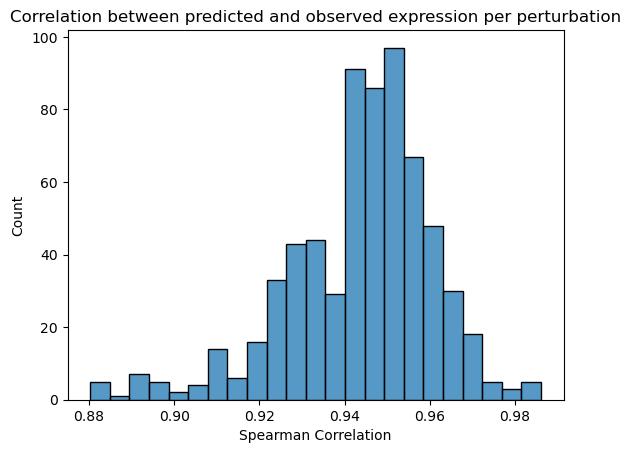

In [9]:
# plot train correlation distribution vs test correlation distribution
test_corr = np.array(test_corr_singles + test_corr_combos)[:, 1].astype(float)
sns.histplot(test_corr, label="test_corr")
plt.title("Correlation between predicted and observed expression per perturbation")
plt.xlabel("Spearman Correlation")
plt.show()

In [8]:
np.savetxt(
    "figures/reconstruction_spearmans/pertspectra_norman_spearman_correlations.csv",
    test_corr,
    delimiter=",",
    fmt="%.2f",
)

# Perturbation Embedding Heatmap

## Hierarchical Clustering + Enrichment
- Perform enrichment tests (gprofiler) on hierarchical clustering of perturbation embeddings

In [ ]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist, squareform

# Compute the pairwise distances
pert_embeddings_df = pd.DataFrame(
    adata.uns["SPECTRA_pert_scores"], index=adata.uns["Spectra_pert_labels"]
)
df = pert_embeddings_df.drop(index=["basal", "ctrl"])

distance = "euclidean"
distances = pdist(df.values, metric=distance)

# Convert the distances into a square distance matrix
distance_matrix = pd.DataFrame(squareform(distances), index=df.index, columns=df.index)
# distance_matrix = (distance_matrix - distance_matrix.min()) / (distance_matrix.max() - distance_matrix.min())

# Compute the linkage matrix using the condensed distance matrix
linkage_matrix = linkage(distance_matrix, method="ward")

# Plot the dendrogram (optional)
dendro = dendrogram(linkage_matrix, no_plot=True)

# Assign clusters
max_d = 0.09
clusters = fcluster(linkage_matrix, max_d, criterion="distance")

# Create a color palette for clusters
palette = sns.color_palette("husl", len(np.unique(clusters)))

# Map each cluster id to a color
cluster_colors = [palette[i - 1] for i in clusters]

# Show the plot
plt.show()

clustermap = sns.clustermap(
    distance_matrix, cmap="viridis_r", row_colors=cluster_colors
)
clustermap.fig.suptitle(f"Pairwise {distance} distance of perturbation latent vectors")
# clustermap.ax_row_dendrogram.set_visible(False)
clustermap.ax_col_dendrogram.set_visible(False)
clustermap.cax.set_visible(False)
plt.show()

In [11]:
# extract clusters and perform gprofiler
index_names = list(distance_matrix.index)
cluster_df = pd.DataFrame({"Pert": index_names, "Cluster": clusters})
cluster_process = {}
for cluster_id in np.unique(clusters):
    points_in_cluster = cluster_df[cluster_df["Cluster"] == cluster_id]["Pert"].tolist()
    gprofiler_in = pd.DataFrame(points_in_cluster, columns=["gene_symbol"])
    res = get_gprofiler(gprofiler_in)
    cluster_process[cluster_id] = res[res["p_value"] <= 0.05]

In [ ]:
# Create descriptions for each cluster (for demonstration purpose)
cluster_descriptions = {
    1: "Developmental processes, kinase activity",
    2: "Tyrosine phosphatase activity",
    3: "Transcription factor activity, DNA binding",
    4: "Embryonic development",
    5: "No signficant gprofiler hits",
    6: "Kinase inhibitor activity",
    7: "No signficant gprofiler hits",
    8: "Embryonic morphogenesis",
    9: "DNA-binding transcription activator",
    10: "RNA polymerase II transcription regulation",
    11: "C/EBP complex",
}

# Create a consistent color palette
unique_clusters = sorted(np.unique(clusters))
palette = sns.color_palette("husl", len(unique_clusters))
cluster_colors = [palette[i - 1] for i in clusters]
cluster_colors = {cid: palette[i] for i, cid in enumerate(unique_clusters)}

# Create clustermap using consistent colors
row_colors = [cluster_colors[cid] for cid in clusters]
clustermap = sns.clustermap(
    distance_matrix, cmap="viridis_r", row_colors=[palette[i - 1] for i in clusters]
)
clustermap.ax_row_dendrogram.set_visible(False)
# clustermap.ax_col_dendrogram.set_visible(False)
clustermap.savefig(
    "figures/figure_pngs/pertspectra_norman_clustermap.png",
    dpi=600,
    bbox_inches="tight",
)

# Prepare data for the table
cluster_data = {
    "Cluster ID": unique_clusters,
    "Description": [cluster_descriptions[cid] for cid in unique_clusters],
}

cluster_df = pd.DataFrame(cluster_data)

# Plot the table with colors matching the clustermap
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("off")
ax.axis("tight")

# Create table while applying the color to the row background
table = ax.table(
    cellText=cluster_df.values,
    colLabels=["Cluster ID", "Description"],
    cellColours=[[cluster_colors[cid]] * 2 for cid in cluster_df["Cluster ID"]],
    cellLoc="center",
    loc="center",
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig(
    "figures/figure_pngs/pertspectra_norman_clustermap_descriptions.png",
    dpi=600,
    bbox_inches="tight",
)
plt.show()

In [181]:
# save
with open(
    "figures/pert_embedding_cluster_gprofiler/MODEL_norman_pert_emb_gprofiler.pickle",
    "wb",
) as handle:
    pickle.dump(cluster_process, handle, protocol=pickle.HIGHEST_PROTOCOL)

## PR Curve+AUC
- AUCPR using prior graph as binary label

In [12]:
aucpr_df, f1_df, pr_dict = auprc(distance_matrix)
print(aucpr_df)
print(f1_df)
aucpr_df.to_csv("figures/pert_embedding_recall/pertspectra_norman_aucpr.csv")
f1_df.to_csv("figures/pert_embedding_recall/pertspectra_norman_f1.csv")

               AUC
StringDB  0.753048
CORUM     0.946676
                F1  Threshold
StringDB  0.829457   0.973018
CORUM     0.972222   1.000000


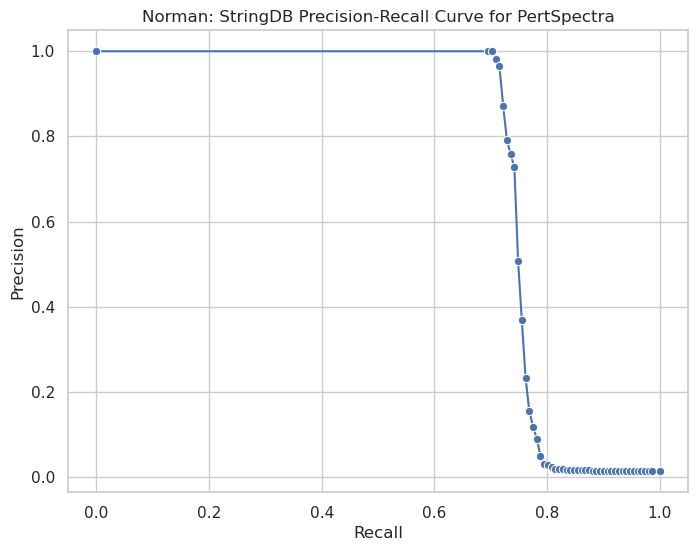

In [13]:
prior = "StringDB"
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.lineplot(
    x=pr_dict[prior]["recall"],
    y=pr_dict[prior]["precision"],
    marker="o",
    label="Precision-Recall Curve",
)

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Norman: StringDB Precision-Recall Curve for PertSpectra")
plt.legend().set_visible(False)
plt.show()

# Interpretability of our learned latent space

## Factor Enrichment
- GSEA on log transformed latent-by-gene factors
- Then associate each perturbation to its top latent factors

In [ ]:
factor_to_go = factor_enrichment_gsea(adata, adata.uns["SPECTRA_factors"], fdr=5e-2)

2024-12-13 18:26:07,684 [INFO] Parsing data files for GSEA.............................
2024-12-13 18:26:07,780 [INFO] 17889 gene_sets have been filtered out when max_size=300 and min_size=10
2024-12-13 18:26:07,781 [INFO] 1096 gene_sets used for further statistical testing.....
2024-12-13 18:26:07,781 [INFO] Start to run GSEA...Might take a while..................
2024-12-13 18:26:35,994 [INFO] Congratulations. GSEApy runs successfully................



163


2024-12-13 18:26:38,066 [INFO] Parsing data files for GSEA.............................
2024-12-13 18:26:38,167 [INFO] 17889 gene_sets have been filtered out when max_size=300 and min_size=10
2024-12-13 18:26:38,168 [INFO] 1096 gene_sets used for further statistical testing.....
2024-12-13 18:26:38,169 [INFO] Start to run GSEA...Might take a while..................
2024-12-13 18:27:06,036 [INFO] Congratulations. GSEApy runs successfully................



298


2024-12-13 18:27:08,089 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-12-13 18:27:08,090 [INFO] Parsing data files for GSEA.............................
2024-12-13 18:27:08,186 [INFO] 17889 gene_sets have been filtered out when max_size=300 and min_size=10
2024-12-13 18:27:08,187 [INFO] 1096 gene_sets used for further statistical testing.....


In [ ]:
# filter and add description to processes
go_df = read_aws_csv("s3://pert-spectra/references/GO_to_Description.txt")
go_df.set_index("Term", inplace=True)
go_dict = go_df.to_dict()["Description"]

filtered_factor_to_go = {}
for i in factor_to_go:
    proc = factor_to_go[i]
    proc["descr"] = [go_dict[x] for x in proc["GO_ID"]]
    filtered_factor_to_go[i] = proc

In [ ]:
with open(
    "figures/factor_enrichments/pertspectra_norman_factor_enrichment.pickle", "wb"
) as handle:
    pickle.dump(filtered_factor_to_go, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Proposed Metric 2 continued: Overlap with prior knowledge/ground truth (stringdb)
- Group A: a set of GO terms associated with a perturbation (either drivers from msigdb, or from literature) and its neighbors in stringdb
- Group B: a set of GO terms from the interpretability analysis
- Hypergeometric test on the overlap of the two groups

In [15]:
# load precomputed factor_to_go dict if available
filtered_factor_to_go = read_aws_pickle(
    "s3://pert-spectra/figures/factor_enrichments/pertspectra_norman_factor_enrichment.pickle"
)

In [17]:
# get neighbors for each perturbation
pert_neighbors = retrieve_stringdb_neighbors(adata.uns["Spectra_pert_labels"])

In [18]:
# construct group A - known processes for each perturbation
gene_sets = read_aws_pickle("s3://pert-spectra/references/GO_to_Gene.pickle")
# BP only go terms
go_reference = read_aws_csv("s3://pert-spectra/references/GO_terms.txt.gz", zipped=True)
go_bp = go_reference[go_reference["go_category"] == "biological_process"]
go_bp_ids = set(go_bp["go_id"].values)
filtered_go_terms = {key: gene_sets[key] for key in go_bp_ids if key in gene_sets}

# GO terms per perturbation AND its neighbors in stringdb
pert_to_go = {key: set() for key in adata.uns["Spectra_pert_labels"]}
for goterm in filtered_go_terms:
    for pert in adata.uns["Spectra_pert_labels"]:
        if pert in filtered_go_terms[goterm] and set(
            filtered_go_terms[goterm]
        ).intersection(pert_neighbors[pert]):
            pert_to_go[pert].add(goterm)

In [19]:
# construct set B - model identified processes for each perturbation
n = 10  # number of top factors to get processes from
model_pert_to_go = {}
for pert in adata.uns["Spectra_pert_labels"]:
    if pert in ["ctrl", "intergenic", "basal"]:
        continue
    # get top factors
    pert_embeddings_df = pd.DataFrame(
        adata.uns["SPECTRA_pert_scores"], index=adata.uns["Spectra_pert_labels"]
    )
    pert_loading = pert_embeddings_df.loc[pert]
    ctrl_loading = pert_embeddings_df.loc["ctrl"]
    delta_loading = np.abs(np.log(pert_loading) - np.log(ctrl_loading))
    top_n_factors = np.argpartition(np.array(delta_loading), -n)[-n:]
    # get processes
    model_processes = set()
    for f in top_n_factors:
        proc = filtered_factor_to_go[f]
        model_processes = model_processes.union(set(proc["Term"]))
    model_pert_to_go[pert] = model_processes

In [20]:
pvals = perturbation_signal_recovery(
    pert_to_go,
    model_pert_to_go,
    list(filtered_go_terms.keys()),
    list(adata.uns["Spectra_pert_labels"]),
)

Overlap for AHR: 8 out of 12 in researchDB
P-value for AHR: 4.845823421588032e-12
Overlap for ARID1A: 1 out of 16 in researchDB
P-value for ARID1A: 0.18058513844900828
Overlap for BAK1: 4 out of 43 in researchDB
P-value for BAK1: 8.604968054508552e-05
Overlap for BCL2L11: 5 out of 29 in researchDB
P-value for BCL2L11: 3.511897516201057e-05
Overlap for CBL: 4 out of 28 in researchDB
P-value for CBL: 0.00015631895405348394
Overlap for CDKN1A: 15 out of 37 in researchDB
P-value for CDKN1A: 9.94025808969477e-20
Overlap for CDKN1B: 13 out of 38 in researchDB
P-value for CDKN1B: 4.2909462790682503e-16
Overlap for CDKN1C: 4 out of 15 in researchDB
P-value for CDKN1C: 2.365186115944503e-05
Overlap for CEBPA: 7 out of 34 in researchDB
P-value for CEBPA: 2.2822948081394184e-08
Overlap for CEBPB: 10 out of 33 in researchDB
P-value for CEBPB: 5.670390667165458e-13
Overlap for CEBPE: 2 out of 9 in researchDB
P-value for CEBPE: 0.0017532384752871838
Overlap for CITED1: 7 out of 14 in researchDB
P-va

In [19]:
# save as csv for visualization
pd.DataFrame.from_dict(data=pvals, orient="index").to_csv(
    "figures/process_recovery_hypergeo_pvals/pertspectra_norman_hypergeo_neighbors_recovery_pvalues.csv",
    header=False,
)